# Correcting relative hydration free energies using deep neural networks

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Path-variables" data-toc-modified-id="Path-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Path variables</a></span></li><li><span><a href="#Global-variables" data-toc-modified-id="Global-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Global variables</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Model-hyper-parameter-statistics" data-toc-modified-id="Model-hyper-parameter-statistics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model hyper-parameter statistics</a></span></li><li><span><a href="#External-testing" data-toc-modified-id="External-testing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>External testing</a></span><ul class="toc-item"><li><span><a href="#Load-testing-data" data-toc-modified-id="Load-testing-data-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Load testing data</a></span><ul class="toc-item"><li><span><a href="#FreeSolve-database" data-toc-modified-id="FreeSolve-database-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>FreeSolve database</a></span></li><li><span><a href="#External-test-set" data-toc-modified-id="External-test-set-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>External test set</a></span><ul class="toc-item"><li><span><a href="#Features-and-labels-format" data-toc-modified-id="Features-and-labels-format-6.1.2.1"><span class="toc-item-num">6.1.2.1&nbsp;&nbsp;</span>Features and labels format</a></span></li><li><span><a href="#FreeSolve-format" data-toc-modified-id="FreeSolve-format-6.1.2.2"><span class="toc-item-num">6.1.2.2&nbsp;&nbsp;</span>FreeSolve format</a></span></li></ul></li></ul></li><li><span><a href="#Original-$\Delta-G_{hydr}$" data-toc-modified-id="Original-$\Delta-G_{hydr}$-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Original $\Delta G_{hydr}$</a></span></li><li><span><a href="#Predict-$\Delta-G_{offset}$" data-toc-modified-id="Predict-$\Delta-G_{offset}$-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Predict $\Delta G_{offset}$</a></span></li><li><span><a href="#$\Delta-G_{hydr}$-correction" data-toc-modified-id="$\Delta-G_{hydr}$-correction-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>$\Delta G_{hydr}$ correction</a></span></li></ul></li><li><span><a href="#Removing-outlier" data-toc-modified-id="Removing-outlier-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Removing outlier</a></span></li></ul></div>

## Imports

In [1]:
# General:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import csv
import time
import shutil
import logging
import pickle
from tqdm import tqdm_notebook as tqdm

# Statistics:
import scipy
import statistics
from sklearn.metrics import r2_score

# Tensorflow:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# SciKit-Optimise:
from skopt import gp_minimize, dump, load
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Path variables

In [2]:
# Path variables:
path = './'
datasets_dr = '../datasets/'
SDF_dr = datasets_dr + 'sdffiles/'
# output_dr = path + 'output_20_calls/'
# figures_dr = path + 'figures_20_calls/'
output_dr = path + 'output/'
figures_dr = path + 'figures/'
freesolv_loc = datasets_dr + 'freesolv_database.txt'

# clear figures_dr
if os.path.exists(figures_dr):
    shutil.rmtree(figures_dr)
if not os.path.exists(figures_dr):
    os.mkdir(figures_dr)

## Global variables

In [3]:
# Global variables:
model_type = 'DNN'
label_col = 'dGoffset (kcal/mol)'

# DNN global variables
n_calls = 20  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
epochs = 200
best_mae = np.inf

# load in data set
dtrain_df = pd.read_hdf(datasets_dr + 'dtrain_data.h5', key='relative')
num_input_nodes = len(dtrain_df.columns) - 1

## Load data

In [4]:
# gp_minimize object
search_result = load(output_dr + 'gp_minimize_result.pickle')
# lsit of MAE and associated parameters
mae_logger = pd.read_csv(output_dr + 'DNN_statistics.csv')

/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Model hyper-parameter statistics

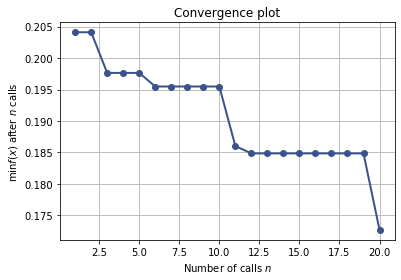

In [5]:
plot_convergence(search_result)
plt.savefig(figures_dr + 'convergence_plot.png')

$offset(x) = exp(x) - calc(x)$

$\Rightarrow exp(x) = offset(x) + calc(x)$

$\Rightarrow correction(x) = offset(x) + calc(x)$

$\Delta offset = offset(a) - offset(b)$

$\Delta correction(x) = \Delta offset(x) + \Delta calc(x)$

## External testing

In [6]:
def plot_scatter(x, y, title, x_label, y_label):
    """
    Returns and saves linear regression scatter plot.
    x: (list) calculated or predicted data.
    y: (list) true or experimental data.
    title: (str) plot title and filename delimitted by underscores. Avoid special characters.
    x_label: (str) x-axis label.
    y_label: (str) y-axis label.
    """
    
    # plot scatter
    plt.figure()
    plt.scatter(x, y, color='black', s=8)

    # plot line of best fit
    # https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
    plt.plot(np.unique(x),
             np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
             color='black', linewidth=1)

    # axis labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # figure title
    plt.title(title)

    # absolute error
    ae = [abs(i - j) for i, j in zip(x, y)]
    # mean absolute error
    mae = statistics.mean(ae)
    
    # R-squared
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y, x)
    r2 = r_value**2

    # annotate with r-squared and MAE
    string = 'MAE = {}\nR$^2$ = {}\nR = {}'.format(round(mae, 4), round(r2, 4), round(r_value, 4))
    plt.annotate(string, xy=(0, 1),
                 xytext=(12, -12), va='top',
                 xycoords='axes fraction',
                 textcoords='offset points')

    filename = figures_dr + str(title).lower().replace(' ', '_') + '.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))

### Load testing data

#### FreeSolve database

In [7]:
# load freesolv
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python', index_col='compound id (and file prefix)')
# index
fs_id = freesolv_df.index
# experimentally determined dGhydr
fs_exp = freesolv_df.iloc[:, 2].tolist()
# computationally calculated dGhydr
fs_calc = freesolv_df.iloc[:, 4].tolist()

#### External test set

##### Features and labels format

In [8]:
# load external testing data
dtest_df = pd.read_csv(datasets_dr + 'dtest_data.csv', index_col='ID').sort_index().iloc[:,:-1]
# unpack testing set
dtest_id = dtest_df.index.tolist()
# features
dtest_X = dtest_df.drop(columns=label_col).values
# true computationally calculated labels
dtest_y = dtest_df[label_col].values

##### FreeSolve format

In [9]:
# SAMPL4_Gurthrie df
test_fs_df = freesolv_df.loc[freesolv_df.iloc[:, 6] == 'SAMPL4_Guthrie'].sort_index()

# SAMPL4_Gurthrie experimentally determined dGhydr
test_exp = test_fs_df.iloc[:, 2].tolist()
# convert to relative
test_exp = {key: value for key, value in zip(dtest_id, test_exp)}
dtest_exp = [test_exp[i] - test_exp[j] for i in test_exp for j in test_exp if not i == j]
dtest_exp_dict = {key: value for key, value in zip(dtest_id, dtest_exp)}

# SAMPL4_Gurthrie computationally calculated dGhydr
test_calc = test_fs_df.iloc[:, 4].tolist()
# convert to relative
test_calc = {key: value for key, value in zip(dtest_id, test_calc)}
dtest_calc = [test_calc[i] - test_calc[j] for i in test_calc for j in test_calc if not i == j]
dtest_calc_dict = {key: value for key, value in zip(dtest_id, dtest_calc)}

### Original $\Delta G_{hydr}$

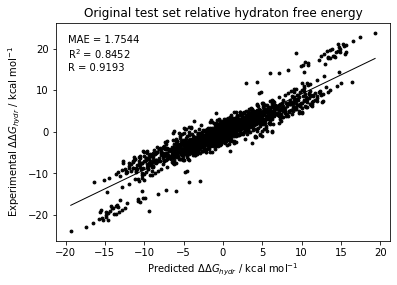

In [10]:
plot_scatter(x=dtest_calc,
             y=dtest_exp,
             title='Original test set relative hydraton free energy',
             x_label='Predicted $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$')

### Predict $\Delta G_{offset}$

In [11]:
# trained model
model = tf.keras.models.load_model(output_dr + 'ddGhydr_' + model_type + '_model.h5')
# predict
dpredict_y = model.predict(dtest_X)
# convert np array to float
dpredict_y = [float(x) for x in dpredict_y]

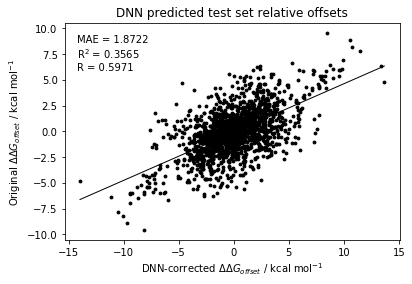

In [12]:
plot_scatter(x=dpredict_y,
             y=dtest_y,
             title='DNN predicted test set relative offsets',
             x_label='DNN-corrected $\Delta \Delta G_{offset}$ / kcal mol$^{-1}$',
             y_label='Original $\Delta \Delta G_{offset}$ / kcal mol$^{-1}$')

### $\Delta G_{hydr}$ correction

In [13]:
dtest_corr = [offset + calc for offset, calc in zip(dpredict_y, dtest_calc)]
dtest_corr_dict = {key: value for key, value in zip(dtest_id, dtest_corr)}

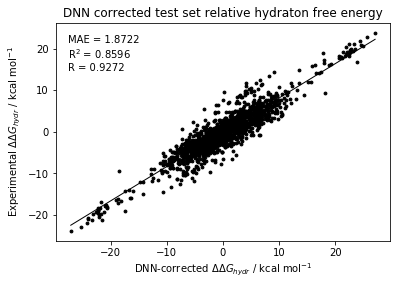

In [14]:
plot_scatter(x=dtest_corr,
             y=dtest_exp,
             title='DNN corrected test set relative hydraton free energy',
             x_label='DNN-corrected $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$')

## Removing outlier

How does removing mobley_4587267 from the training and testing affect the result?

In [15]:
dtest_exp_df = pd.DataFrame.from_dict(dtest_exp_dict, orient='index')
dtest_calc_df = pd.DataFrame.from_dict(dtest_calc_dict, orient='index')

[-30, 30, -30, 30]

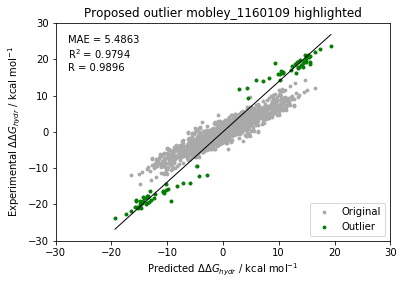

In [16]:
def plot_scatter_outlier(calc, exp, title, x_label, y_label):
    """
    Returns and saves linear regression scatter plot.
    x: (list) calculated or predicted data.
    y: (list) true or experimental data.
    title: (str) plot title and filename delimitted by underscores. Avoid special characters.
    x_label: (str) x-axis label.
    y_label: (str) y-axis label.
    """
    
    plt.figure()
    plt.scatter(calc.iloc[:, 0], exp.iloc[:, 0], color='darkgray', s=8, label='Original')
    
    for index in exp.index:
        if not 'mobley_4587267' in index:
            calc = calc.drop(index=index)
            exp = exp.drop(index=index)
            
    x = calc.iloc[:, 0]
    y = exp.iloc[:, 0]
    
    # plot scatter
    plt.scatter(x, y, color='green', s=8, label='Outlier')

    # plot line of best fit
    # https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
    plt.plot(np.unique(x),
             np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
             color='black', linewidth=1)

    # axis labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # figure title
    plt.title(title)
    plt.legend(loc='lower right')

    # absolute error
    ae = [abs(i - j) for i, j in zip(x, y)]
    # mean absolute error
    mae = statistics.mean(ae)
    
    # R-squared
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y, x)
    r2 = r_value**2

    # annotate with r-squared and MAE
    string = 'MAE = {}\nR$^2$ = {}\nR = {}'.format(round(mae, 4), round(r2, 4), round(r_value, 4))
    plt.annotate(string, xy=(0, 1),
                 xytext=(12, -12), va='top',
                 xycoords='axes fraction',
                 textcoords='offset points')

    filename = figures_dr + str(title).lower().replace(' ', '_') + '.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))


plot_scatter_outlier(calc=dtest_calc_df,
             exp=dtest_exp_df,
             title='Proposed outlier mobley_1160109 highlighted',
             x_label='Predicted $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$')

plt.axis([-30, 30, -30, 30])

In [17]:
dtest_exp_df = pd.DataFrame.from_dict(dtest_exp_dict, orient='index')
dtest_calc_df = pd.DataFrame.from_dict(dtest_calc_dict, orient='index')
dtest_corr_df = pd.DataFrame.from_dict(dtest_corr_dict, orient='index')

for index in dtest_exp_df.index:
    if 'mobley_4587267' in index:
        dtest_calc_df = dtest_calc_df.drop(index=index)
        dtest_exp_df = dtest_exp_df.drop(index=index)
        dtest_corr_df = dtest_corr_df.drop(index=index)

[-30, 30, -30, 30]

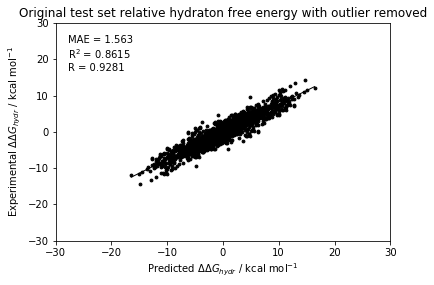

In [18]:
plot_scatter(x=dtest_calc_df.iloc[:, 0],
             y=dtest_exp_df.iloc[:, 0],
             title='Original test set relative hydraton free energy with outlier removed',
             x_label='Predicted $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$')

plt.axis([-30, 30, -30, 30])

[-30, 30, -30, 30]

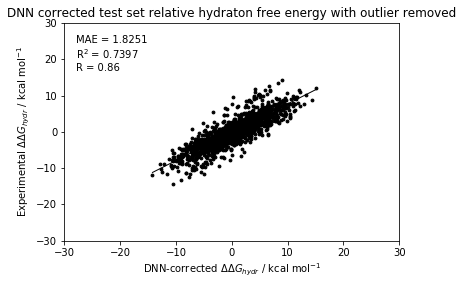

In [19]:
plot_scatter(x=dtest_corr_df.iloc[:, 0],
             y=dtest_exp_df.iloc[:, 0],
             title='DNN corrected test set relative hydraton free energy with outlier removed',
             x_label='DNN-corrected $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta \Delta G_{hydr}$ / kcal mol$^{-1}$')

plt.axis([-30, 30, -30, 30])